In [1]:
import pandas as pd
import os

import numpy as np
import scipy.stats as st

import time

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline


from IPython.display import clear_output

from scipy.signal import butter, filtfilt, iirnotch, lombscargle, resample, ellip
from scipy import signal

## Custom pdf

In [2]:
import numpy as np


def ass(tail_weigth = .05):
    if np.random.rand() > tail_weigth:
        return np.random.rand()*60
    x = abs(np.random.normal())
    while st.norm.sf(x)>tail_weigth:
        x = abs(np.random.normal())
    return 60 + x - st.norm.ppf(1-tail_weigth)

def extract_from_ass(num_samples, tail_weigth = .05):
    return np.array([ass(tail_weigth) for _ in range(num_samples)])

In [3]:
X = extract_from_ass(100000)
len(np.where(X>60)[0])

4971

## CSV reading function for pureEEG

In [4]:
def read_EEG_csv(title):
    db2 = pd.read_csv(title + '.md.csv', skiprows=[0])
    header = {}
    f = open(title + '.md.csv', 'r')
    for h in f.readline().split(','):
        hh = h.split(':')
        header[hh[0].replace(' ', '')] = hh[1].split()
    f.close()
    db2.columns = header['labels']
    db2.TIME_STAMP_ms += db2.TIME_STAMP_s*1000
    
    db1 = pd.read_csv(title + '.csv', skiprows=[0])
    header = {}
    f = open(title + '.csv', 'r')
    for h in f.readline().split(','):
        hh = h.split(':')
        header[hh[0].replace(' ', '')] = hh[1].split()
    f.close()
    db1.columns = header['labels']
    db1.TIME_STAMP_ms += db1.TIME_STAMP_s*1000
    
    database = pd.merge(db1, db2, on = 'TIME_STAMP_ms', how = 'left', suffixes=['_eeg', '_md'])
    header['labels'] = list(database.columns)
    
    return database.ffill(), header

In [5]:
path = os.getcwd() + '\\supervised data\\'
f = path + 'Tom-1-22.06.17-17.25.35'
database, header =  read_EEG_csv(f)

In [6]:
print(database.head(100))

    COUNTER  INTERPOLATED          AF3           F7           F3          FC5  \
0     116.0           0.0  4021.538330  3950.256348  4116.922852  4103.076660   
1     117.0           0.0  4023.076904  3950.256348  4114.871582  4107.692383   
2     118.0           0.0  4017.948730  3949.230713  4109.743652  4102.563965   
3     119.0           0.0  4021.538330  3957.435791  4111.281738  4098.974121   
4     120.0           0.0  4026.153809  3959.487061  4109.743652  4100.000000   
5     121.0           0.0  4025.128174  3956.923096  4111.281738  4102.051270   
6     122.0           0.0  4032.307617  3964.102539  4123.589844  4107.179199   
7     123.0           0.0  4042.563965  3970.769043  4126.153809  4109.743652   
8     124.0           0.0  4048.205078  3977.435791  4123.589844  4112.820312   
9     125.0           0.0  4053.333252  3977.948730  4130.256348  4110.256348   
10    126.0           0.0  4060.000000  3974.871582  4137.436035  4109.743652   
11    127.0           0.0  4

## Filtering

In [80]:
wave = np.asarray(database["AF3"])
print(wave.shape)

time = np.asarray(database['TIME_STAMP_ms'])
time = time
times = (time[-1] - time[0]) /1000.0
print(times/60)
print(wave.shape[0]/128)

time = time /1000.0
time = list(np.floor(time))
print(time.count(23367))

TypeError: cannot do slice indexing on <class 'pandas.indexes.numeric.Int64Index'> with these indexers [AF3] of <class 'str'>

In [10]:
print(wave[50])

4073.84594727


In [11]:
fs = 128
f0 = 50.0/6.2
f1 = 1/6.2
Q = 15.0
w0 = f0/(fs/2)
w1 = f1/(fs/2)

# b, a = ellip(2, 3, 100.0, w1, "highpass")
d, c = butter(4, w1, "highpass")
f, e = iirnotch(w0, Q)

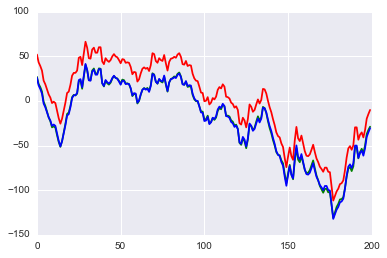

In [12]:
# dat2 = filtfilt(b, a, wave)
dat3 = filtfilt(d, c, wave)
dat2 = filtfilt(f, e, dat3)

plt.plot(wave[1800:2000] - np.mean(wave[1800:2000]), 'r')
plt.plot(dat2[1800:2000] , 'g')
plt.plot(dat3[1800:2000] , 'b')

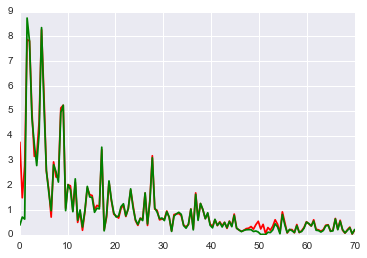

In [13]:
wave2 = wave[:12800] - np.mean(wave[:12800])
normval = wave2.shape[0]
steps = np.linspace(0.0, len(wave2)/(fs), len(wave2))
freqs = np.linspace(0.01, 70.0, 140)
pgram = lombscargle(steps, wave2, freqs)
pgram2 = lombscargle(steps, dat2[:12800] - np.mean(dat2[:12800]), freqs)
pgram3 = lombscargle(steps, dat3[:12800] - np.mean(dat3[:12800]), freqs)
# plt.subplot(3,1,1)
plt.plot(freqs, np.sqrt(4*(pgram/normval)), "r")
# plt.subplot(3,1,2)
plt.plot(freqs, np.sqrt(4*(pgram2/normval)), "g")
# plt.subplot(3,1,3)
# plt.plot(freqs, np.sqrt(4*(pgram3/normval)), "b")

## Motor Noise Removal

In [14]:
filtered = dat2

In [67]:
# stats
minimum = min(filtered)
maximum = max(filtered)
mean = np.mean(filtered)
stdev = np.std(filtered, dtype="float64")
start = 63000
end = 70000

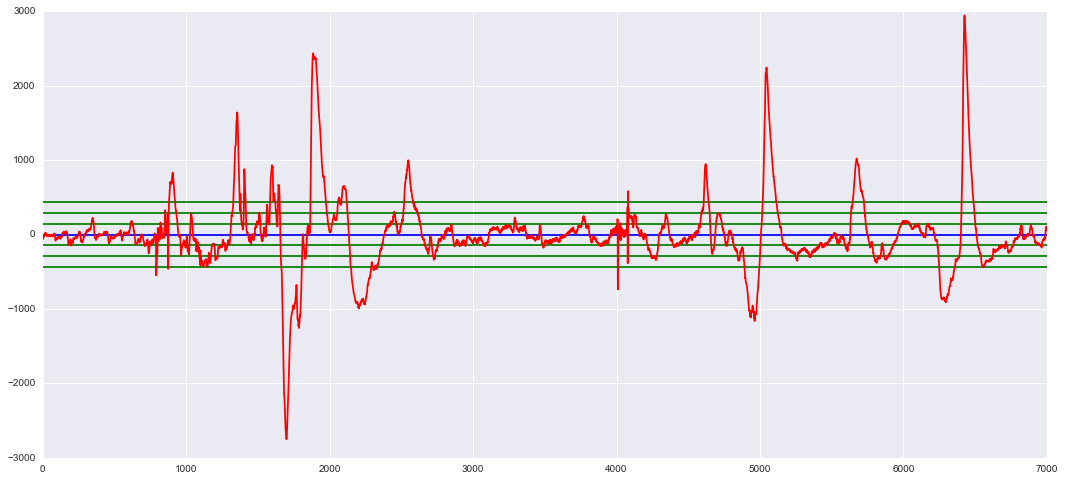

In [68]:
# visualization
def visualize_range(wave, mean, stdev, start, end):
    xrange = len(wave[start:end])
    plt.figure(figsize=[18, 8])
    plt.plot([0, xrange],[mean, mean], 'b')
    plt.plot([0, xrange], [mean+stdev, mean+stdev], 'g')
    plt.plot([0, xrange], [mean-stdev, mean-stdev], 'g')
    plt.plot([0, xrange], [mean+2*stdev, mean+2*stdev], 'g')
    plt.plot([0, xrange], [mean-2*stdev, mean-2*stdev], 'g')
    plt.plot([0, xrange], [mean+3*stdev, mean+3*stdev], 'g')
    plt.plot([0, xrange], [mean-3*stdev, mean-3*stdev], 'g')
    plt.plot(wave[start:end], 'r')
    
visualize_range(filtered, mean, stdev, start, end)

In [69]:
filtered = filtered - mean
mask = np.abs(filtered) - 3 * stdev
mask[mask > 0] = 0.0
mask[mask < 0] = 1.0
filtered2 = mask * filtered

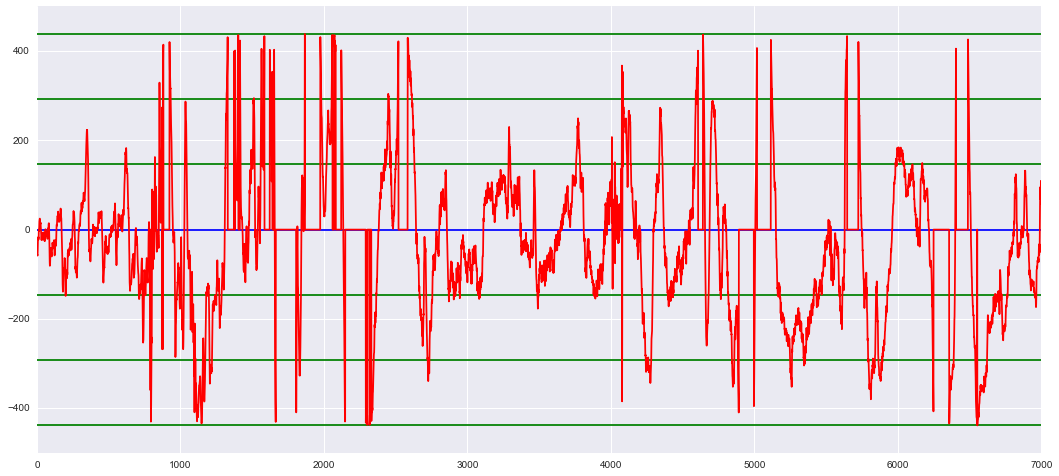

In [70]:
visualize_range(filtered2, 0.0, stdev, start, end)

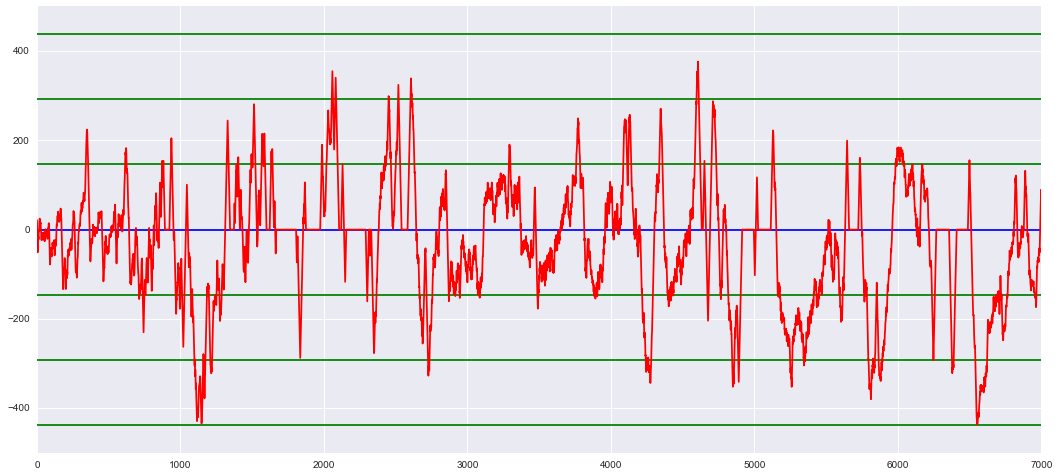

In [71]:
filtered3 = np.copy(filtered2)
for i in range(len(filtered2) -1):
    if filtered3[i] - filtered3[i+1] > stdev / 10.0:
        filtered3[i+1] = filtered3[i] - stdev / 10.0
    elif filtered3[i] - filtered3[i+1] < - stdev / 10.0:
        filtered3[i+1] = filtered3[i] + stdev / 10.0
        
visualize_range(filtered3, 0.0, stdev, start, end)

In [79]:
x = np.ones([20000, 14])
x[:,2] = x[:,2] * 4.0
y = np.mean(x, axis=0)
z = np.std(x, dtype="float64", axis=0)
print(z)
print(y)
print(x-y-z)
print((x-y).shape)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  1.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(20000, 14)


## Wave visualization

In [7]:
def wave_visualization(wave, mi = 3500, ma = 4800, n = 10**3, start = 0):
    vector = wave[start:]
    i = 1
    while len(vector > n):
        plt.figure(figsize=[18, 8], )
        plt.plot(vector[:n])
        plt.ylim((mi, ma))
        plt.title(str(i*n - n + start) + ' to ' + str(i*n + start)) 
        i += 1
        vector = vector[n:]
        plt.show()
        time.sleep(0.05)
        raw_input("Press Enter to continue")
        clear_output(wait=True)
    plt.plot(vector)

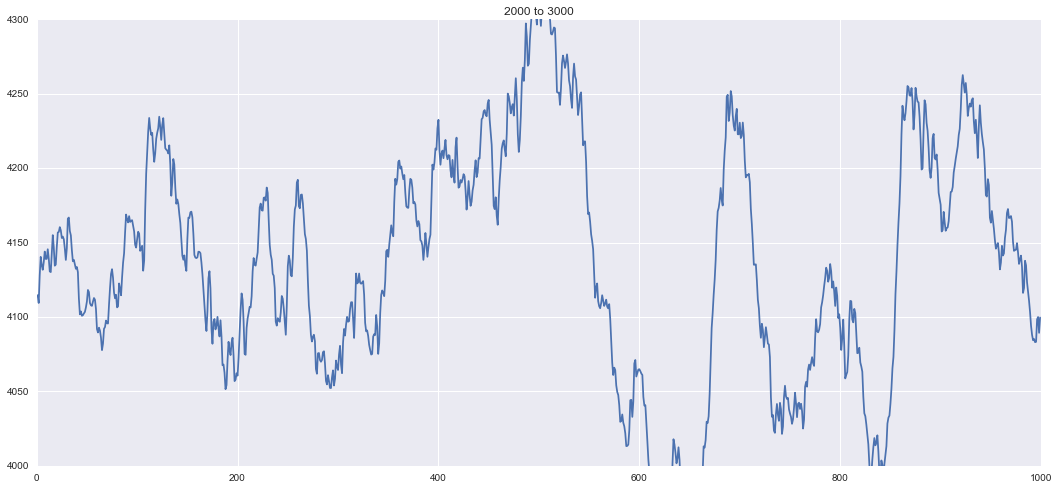

AttributeError: 'list' object has no attribute 'sleep'

In [54]:
wave_visualization(dat2, mi = 4000, ma = 4300, start = 2000)